In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [53]:
loader = SlackDataLoader("../src/anonymized/")
channel = loader.get_channels()
all_data = []
all_messages = []
for i in channel:
    data = loader.slack_parser(f"../src/anonymized/{i['name']}/")
    all_data.append(data)

for j in channel:
    messages = loader.slack_parser(f"../src/anonymized/{j['name']}/")
    all_messages.append(messages)

# print(all_messages)
df = pd.concat(all_data, ignore_index=True)
# print (df.columns)
# df.head(20)

In [8]:
# Who are the top 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
top_10_users = user_reply_counts.head(10)
# print(top_10_users)
pd.DataFrame({'sender_name': top_10_users.index,
'reply_count': top_10_users.values})

,sender_name,reply_count
0,Cristian Wilson,620
1,Vanessa Norman,462
2,Brian Odom,367
3,Brenda Hernandez,307
4,Michelle Lewis,306
5,April Lucas,302
6,Travis Butler,299
7,Amy Leon,282
8,Joshua Rhodes,247
9,Brady Rhodes,242


In [9]:
# Who are the bottom 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
bottom_10_users = user_reply_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index,
'reply_count': bottom_10_users.values})

,sender_name,reply_count
0,Randy Miller,4
1,Leah Newton,2
2,Blake Scott,0
3,Patrick Hernandez,0
4,Patricia Thomas,0
5,Slackbot,0
6,Christopher Case,0
7,Holly Whitaker,0
8,Erica Munoz,0
9,David Scott,0


In [44]:
# Who are the top 10  users by mention count?
mentioned_users = utils.get_tagged_users(df)
loader.get_users()

users_map = loader.get_user_map()[0]
user_names_list = pd.DataFrame({
    'user_id' : list(users_map.keys()),
    'user_name': list(users_map.values())
})

user_ids = []
for id in mentioned_users:
	if id:
		user_ids.append(id[0][1:])

all_mentioned_ids = pd.DataFrame({'user_id': user_ids})


mentioned_users = user_names_list.merge(all_mentioned_ids, on='user_id', how='inner')
mentioned_users_count = mentioned_users.groupby('user_id').value_counts()
top_10_user = mentioned_users_count.sort_values(ascending=False).head(10)
pd.DataFrame(top_10_user)

,,count
user_id,user_name,
U03V1AM5TFA,Vanessa,174
U03TEPYRM2P,Garrett,165
U03UVHCV6KB,Travis,149
U03UUR571A5,Amy,143
U03UG32J3PC,April,139
U03UG4Q7V42,Phillip,111
U03UD68RQH3,Brady,110
U03UJGP0C68,Judith,109
U03UJKJGRAQ,Brian,102


In [45]:
# Who are the bottom 10  users by mention count?
bottom_10_user = mentioned_users_count.sort_values(ascending=False).tail(10)
pd.DataFrame(bottom_10_user)

,,count
user_id,user_name,
U03U1J51VFZ,Cheryl,11
U03UG569P7U,Melissa,7
U03UJGFG2HJ,Vernon,6
U03UKGSDGSG,Leah,5
U03U1FQKEMV,Steven,3
U03UD63A8PP,Randy,3
U03TNP8Q8CT,Bethany,3
U03UG1RTXAP,Carol,3
U03UYNR4TS4,Patrick,2


In [11]:
# Who are the top users by Message count?
user_message_counts = df['sender_name'].value_counts()
top_10_users = user_message_counts.head(10)
pd.DataFrame({'sender_name': top_10_users.index, 'message_count': top_10_users.values}) 

,sender_name,message_count
0,Vanessa Norman,1288
1,Amy Leon,1150
2,Travis Butler,1075
3,April Lucas,991
4,Brenda Hernandez,843
5,Cristian Wilson,831
6,Phillip Atkins,754
7,Brady Rhodes,641
8,Judith Bolton,574
9,Joshua Rhodes,519


In [12]:
# Who are the bottom users by Message count?
bottom_10_users = user_message_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index, 'message_count': bottom_10_users.values})

,sender_name,message_count
0,Leah Newton,10
1,Patricia Thomas,8
2,Randy Miller,7
3,Patrick Hernandez,5
4,Slackbot,3
5,Erica Munoz,1
6,Christopher Case,1
7,Holly Whitaker,1
8,David Scott,1
9,Blake Scott,1


In [68]:
# Who are the top users by Reaction count?


In [ ]:
# Who are the bottom users by Reaction count?

In [69]:
# What are the top 10 messages by Replies?
# processes = utils.process_msgs(all)
# print(processes)

In [70]:
# message_list = utils.get_msgs_df_info(df)
# print(message_list)

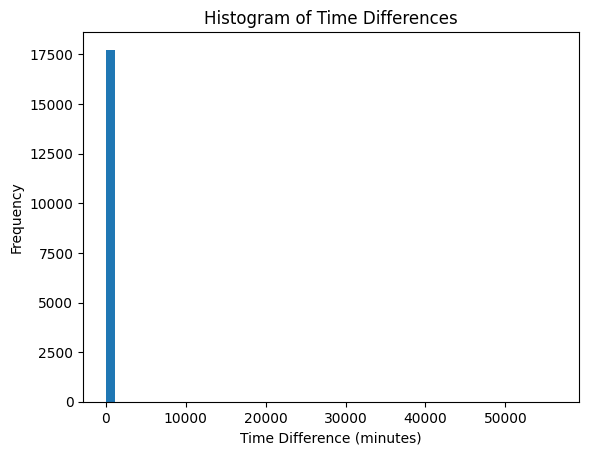

In [61]:
# distribution of time differences
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'])  # convert to datetime
# df['msg_sent_time']
df = df.sort_values('msg_sent_time')
df['time_diff'] = df['msg_sent_time'].diff()
# print(df['time_diff'].describe())

df['time_diff_minutes'] = df['time_diff'].dt.total_seconds() / 60 # Convert the time differences to minutes

# Plot a histogram of the time differences
plt.hist(df['time_diff_minutes'].dropna(), bins=50)
plt.title('Time Differences')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

In [2]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [38]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

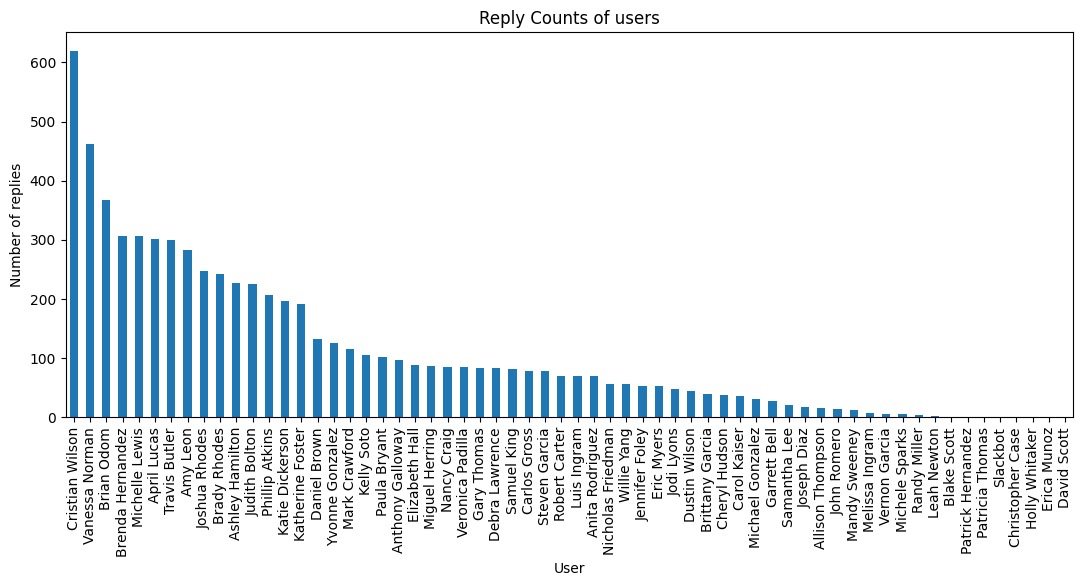

In [47]:
# which user has the highest number of reply counts?
def plot_highest_reply_count(data: DataFrame):
    gr_df = data.groupby('sender_name')['reply_count'].sum()
    gr_df = gr_df.sort_values(ascending=False)
    gr_df.plot(kind='bar', figsize=(13, 5))
    
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

plot_highest_reply_count(df)

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?